# Species distribution modeling
- 과거 관측치와 14개의 환경 변수를 고려하여 남아메리카의 두 동물의 지리적 분포를 모델링한다.
- 양성 예제만 있기 때문에, 문제를 밀도 추정 문제로 취급하고 모델링 도구로 `OneClassSVM`을 사용

## References

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics, svm
from sklearn.datasets import fetch_species_distributions
from sklearn.utils import Bunch

# basemap이 사용 가능한 경우, 해당 기능을 사용한다.
try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False

In [2]:
def construct_grids(batch):
    """batch 객체로부터 맵 그리드를 구성

    Parameter
    ----------
    batch : Batch 객체
        :func:`fetch_species_distributions`에서 반환된 객체

    Returns
    -------
    (xgrid, ygrid) : 1차원 배열
        batch.coverages에 해당하는 그리드이다.
    """
    # 모서리 셀의 x,y 좌표 얻기 
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # 그리드 셀의 x 좌표 얻기 
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # 그리드 셀의 y 좌표 얻기
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

In [3]:
def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """특정 생물에 대한 정보를 포함하는 묶음을 생성

    테스트/훈련 레코드 배열을 사용하여 주어진 종(species) 이름에 해당하는 데이터 추출
    """
    bunch = Bunch(name=" ".join(species_name.split("_")[:2]))
    species_name = species_name.encode("ascii")
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # 원하는 종(species)과 관련된 포인트를 선택
        pts = pts[pts["species"] == species_name]
        bunch["pts_%s" % label] = pts

        # 훈련 및 테스트 포인트 각각에 대한 커버리지 값을 결정
        ix = np.searchsorted(xgrid, pts["dd long"])
        iy = np.searchsorted(ygrid, pts["dd lat"])
        bunch["cov_%s" % label] = coverages[:, -iy, ix].T

    return bunch

________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines using basemap
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines using basemap
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 19.18s


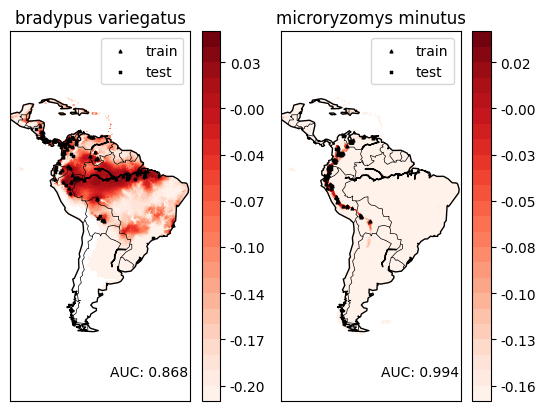

In [4]:
def plot_species_distribution(
    species=("bradypus_variegatus_0", "microryzomys_minutus_0")
):
    """
    종의 분포를 그린다.
    """
    if len(species) > 2:
        print(
            "Note: when more than two species are provided,"
            " only the first two will be used"
        )

    t0 = time()

    # 압축된 데이터를 불러온다.
    data = fetch_species_distributions()

    # 데이터 그리드를 설정
    xgrid, ygrid = construct_grids(data)

    # x, y 좌표로 된 그리드를 설정
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # 각 종에 대해 bunch를 생성
    BV_bunch = create_species_bunch(
        species[0], data.train, data.test, data.coverages, xgrid, ygrid
    )
    MM_bunch = create_species_bunch(
        species[1], data.train, data.test, data.coverages, xgrid, ygrid
    )

    # 평가를 위한 배경 표인트 (그리드 좌표)를 설정
    np.random.seed(13)
    background_points = np.c_[
        np.random.randint(low=0, high=data.Ny, size=10000),
        np.random.randint(low=0, high=data.Nx, size=10000),
    ].T

    # coverages[6]에는 모든 육지 지점의 측정값이 포암되어 있다.
    # 이를 통해 육지와 물 사이를 결정하는 데 도움이 된다.
    land_reference = data.coverages[6]

    # 각 종에 대해 fit하고 예측하고 그린다.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # 특성을 표준화한다.
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end="")
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # South America의 지도를 그린다.
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(
                projection="cyl",
                llcrnrlat=Y.min(),
                urcrnrlat=Y.max(),
                llcrnrlon=X.min(),
                urcrnrlon=X.max(),
                resolution="c",
            )
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(
                X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
            )
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # 학습 데이터를 사용하여 종의 분포를 예측
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # 육지 지점에 대해선만 예측한다.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # 예측 결과의 등고선을 그리기
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format="%.2f")

        # 학습 및 테스트 포인트를 산점도로 표현
        plt.scatter(
            species.pts_train["dd long"],
            species.pts_train["dd lat"],
            s=2**2,
            c="black",
            marker="^",
            label="train",
        )
        plt.scatter(
            species.pts_test["dd long"],
            species.pts_test["dd lat"],
            s=2**2,
            c="black",
            marker="x",
            label="test",
        )
        plt.legend()
        plt.title(species.name)
        plt.axis("equal")

        # 배경 포인트와 관련하여 AUC를 계산
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()